# Spec2Vec - pretrained model comparison

## Main datasets here:
1. "unique-smiles": about 11,000 spectra with unique smiles annotations from GNPS (9550 of which have >= 10 peaks).  
2. "all-GNPS": Ming's selection from GNPS (about 500,000 spectra, 427210,of which with >= peaks)  
3. "all-merged": both 1. and 2. combined

## Outline:
1. Importing, creating documents
2. Plotting functions
3. For benchmarking: molecular similarity
4. Spec2Vec - Spec2Vec trained on **unique smiles** dataset  
5. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 2 decimals  
5.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs  
5.2. Word vectors weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs   
6. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 3 decimals  
6.1. 3 decimals, weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs  
6.2. 3 decimals, d = 400, weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs  
7. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 1 decimals  
7.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs  
8. Spec2Vec - Spec2Vec trained on **all-merged dataset**, 2 decimals  
5.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs 


## 1. Importing, creating documents for reference dataset (1 - unique-smiles)

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data from gnps/unique smiles dataset
#results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"
results_file = "filtered_data_uniquesmiles_minpeak10_loss500_2dec_exp001.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  68392


***
## 2. Plotting functions

In [6]:
import matplotlib
from matplotlib import pyplot as plt

def binned_scatter_plot(bins_x, 
                        bins_y, 
                        H, 
                        edges, 
                        label):
    data_x = []
    data_y = []
    data_z = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))
            
    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('viridis')
    #100*np.array(data_z)**0.5 c=data_y, 
    ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("molecular similarity (f(t,t'))")

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

In [7]:
def plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 1.0):
    
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))
    ref_score_cum = np.array(ref_score_cum)
                         
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    return ref_score_cum

***
## 3. For benchmarking: molecular similarity
Benchmarking - Reference score is molecular similarity (based on mol. fingerprints)

### Calculate/load molecular similarity scores
+ first calculate molecular fingerprints
+ then calculate (or load if file exists) molecular similarity scores.  

Method for calculating fingerprints here can be "morgan1", "morgan2", "morgan3" or "daylight". For morgan fingerprints scores will be based on Dice scores. For "daylight" fingerprint it will be Tanimoto scores. 

In [8]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

### Get molecular similarity matrix (based on molecular fingerprints).  
Still named TANIMOTO, but that is only for daylight fingerprints. For morgan-3 fingerprints it's currently actually using a dice score.

In [9]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
M_sim_morgan3 = MS_functions.tanimoto_matrix(spectra, 
                                              fingerprints_m3,
                                              filename = filename)

Molecular similarity scores found and loaded.


***
# 4. Model trained on dataset itself (unique smiles)
This is (probably) the best performing setting. Now re-calculated from scratch...

In [12]:
#file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_uniquesmiles_d300_w500_iter100_loss500_minpeak10_dec2_exp001.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [13]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.  of  9550  documents. documents.

### Calculate all-vs-all similarity matrix

In [14]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [15]:
remove_diagonal = []
length = M_sim_ctr.shape[0]
for i in range(length):
    remove_diagonal.append(i*length + i)

remove_diagonal = np.array(remove_diagonal) 

In [16]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

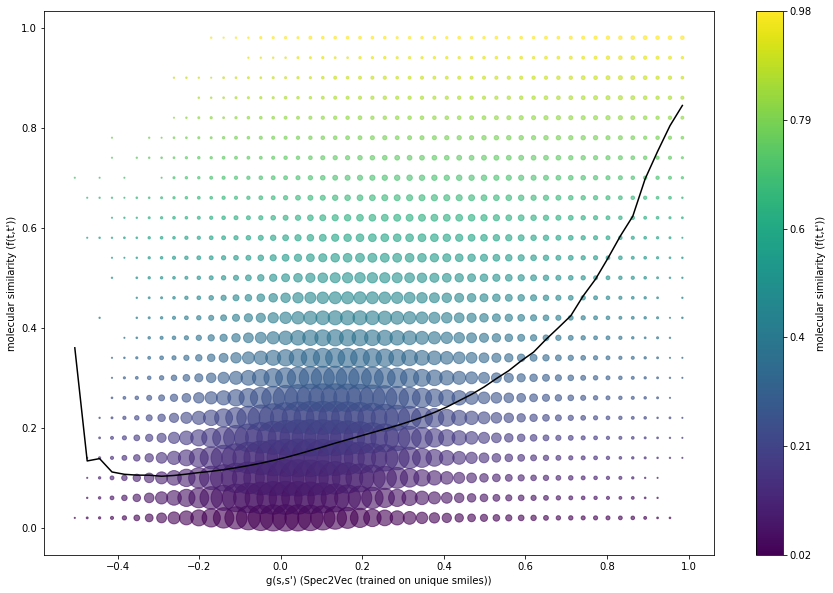

In [17]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on unique smiles)")

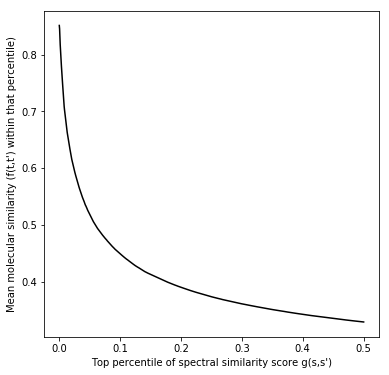

In [18]:
ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_uniquesmiles_dec2_exp001_iter100_d300.npy', ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300)

# 5. Model trained on all-GNPS (> 400,000 spectra)

+ Model was trained on all-GNPS dataset (about 500,000 spectra, 427100 of which were kept and used for training)

In [18]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


***
## 5.1. word vectors weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs

In [27]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.120  of  9550  documents.  of  9550  documents. 590  of  9550  documents. 9550  documents. Calculated centroid vectors for  5700  of  9550  documents. of  9550  documents. Calculated centroid vectors for  6840  of  9550  documents.

In [34]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_2 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [36]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_2.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

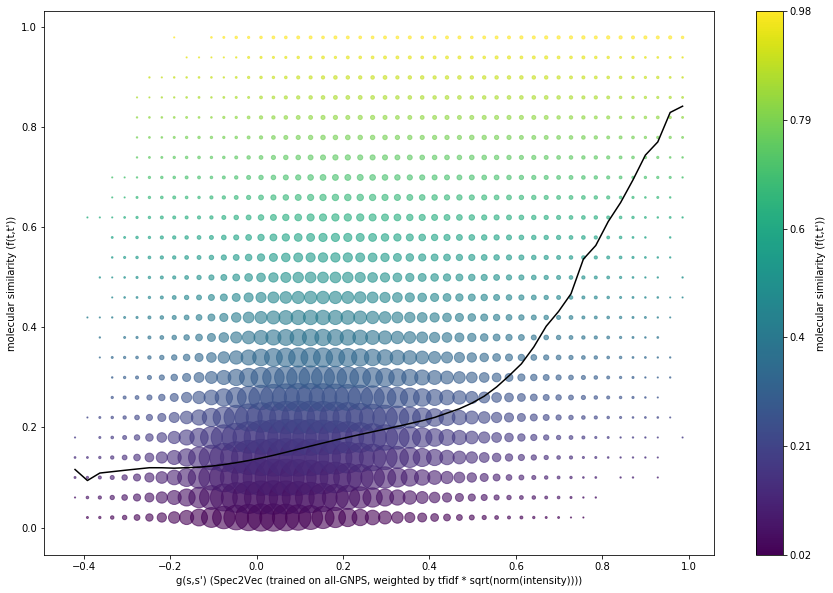

In [37]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on all-GNPS, weighted by tfidf * sqrt(norm(intensity)))")

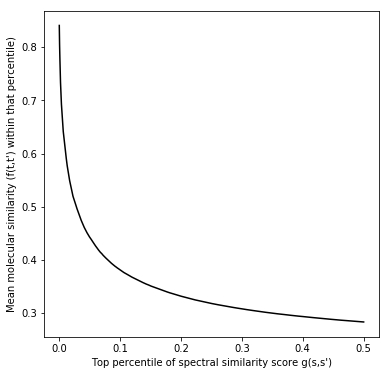

In [38]:
ref_score_w2v_cum_2 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 5.2 word vectors weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs
### w2v model trained on 400 dimensions (instead of 300 as before)

In [31]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d400_w300_iter100_loss500_minpeak10_dec2_no-exp.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=400, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [32]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.10  of  9550  documents. 1220  of  9550  documents.1590  of  9550  documents. Calculated centroid vectors for  1740  of  9550  documents.  documents. Calculated centroid vectors for  9000  of  9550  documents.

In [33]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_2b = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [34]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_2b.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

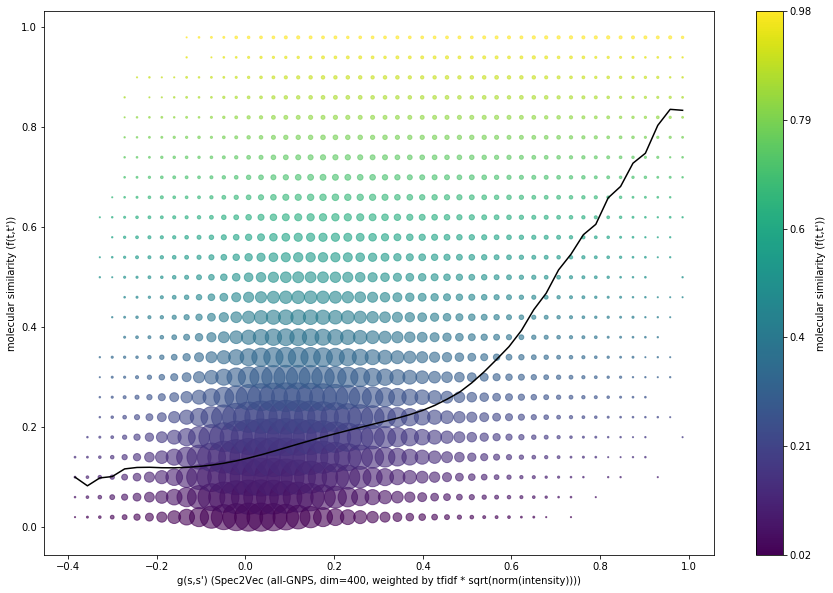

In [35]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (all-GNPS, dim=400, weighted by tfidf * sqrt(norm(intensity)))")

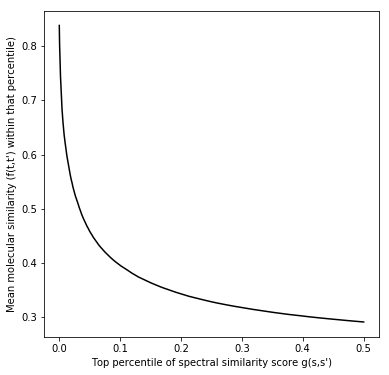

In [36]:
ref_score_w2v_cum_2b = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
# 6. Compare to Word2Vec model trained on all-GNPS with 3 decimal resolution

In [12]:
# Import / Load data from gnps/unique smiles dataset
results_file = "filtered_data_unique_smiles_minpeak10_loss500_3dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 3,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


In [13]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

In [14]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  129170


***
## 6.1. Pre-trained Word2Vec model (3 decimals) + words vectors weighted by tfidf * sqrt(norm(intensity))

In [74]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec3.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [83]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.50  documents. of  9550  documents. 9550  documents.  of  9550  documents. of  9550  documents. of  9550  documents. documents.9550  documents. of  9550  documents.  of  9550  documents.

In [84]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_7 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [85]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_7.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

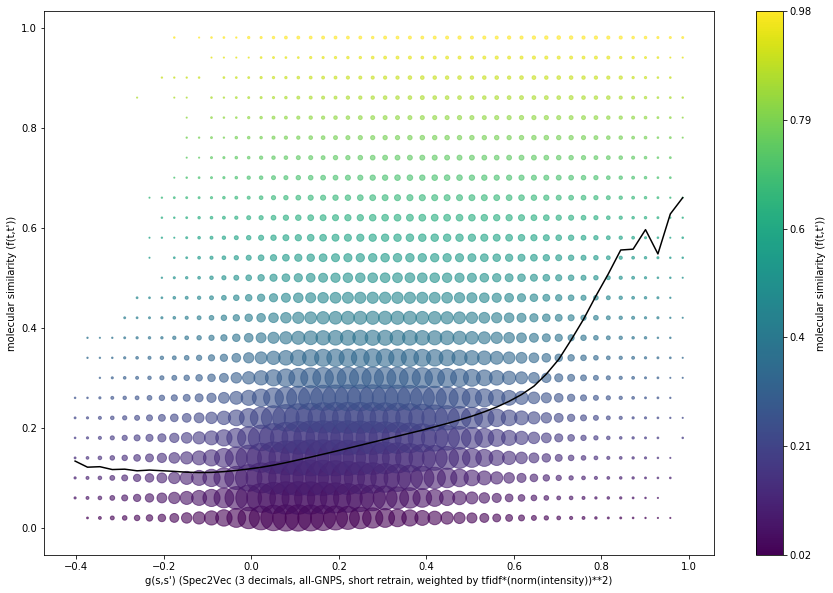

In [86]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (3 decimals, all-GNPS, short retrain, weighted by tfidf*(norm(intensity))**2")

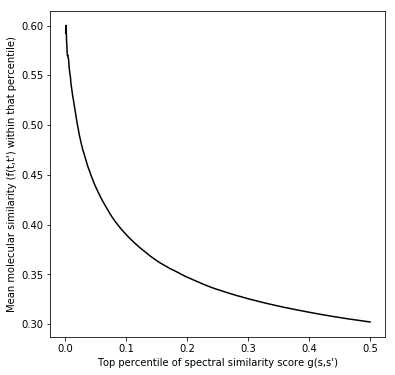

In [87]:
ref_score_w2v_cum_7 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

Set similarity threshold to:  0.7986451588959455


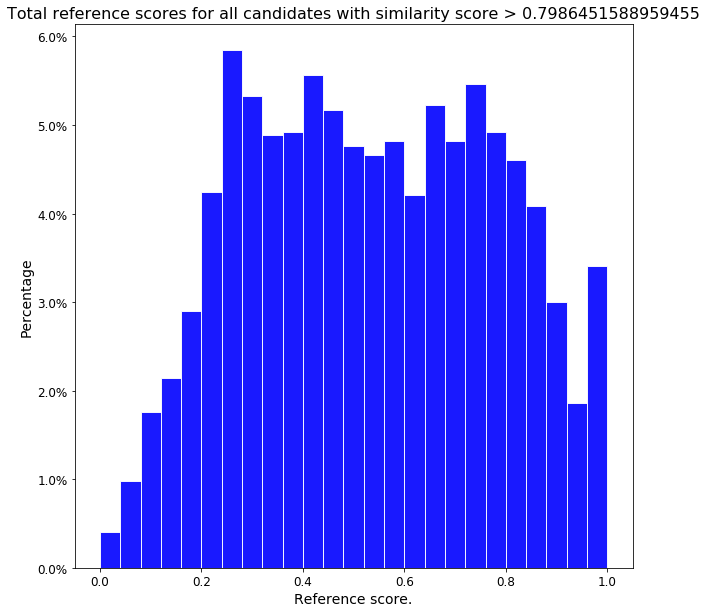

Percentage of highly similar molecules within selection:  55.86 %


In [68]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

***
## 6.2. Pre-trained Word2Vec model (3 decimals) + words vectors weighted by tfidf * sqrt(norm(intensity))
### Word2Vec model: 3 decimals, exp filter=0.01, dimension = 400, iter = 100

In [15]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d400_w300_iter100_loss500_minpeak10_dec3_exp001.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=400, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [16]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
3585  out of  129170  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents. 1960  of  9550  documents.2560  of  9550  documents.

In [19]:
#from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_8 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [24]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_8.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

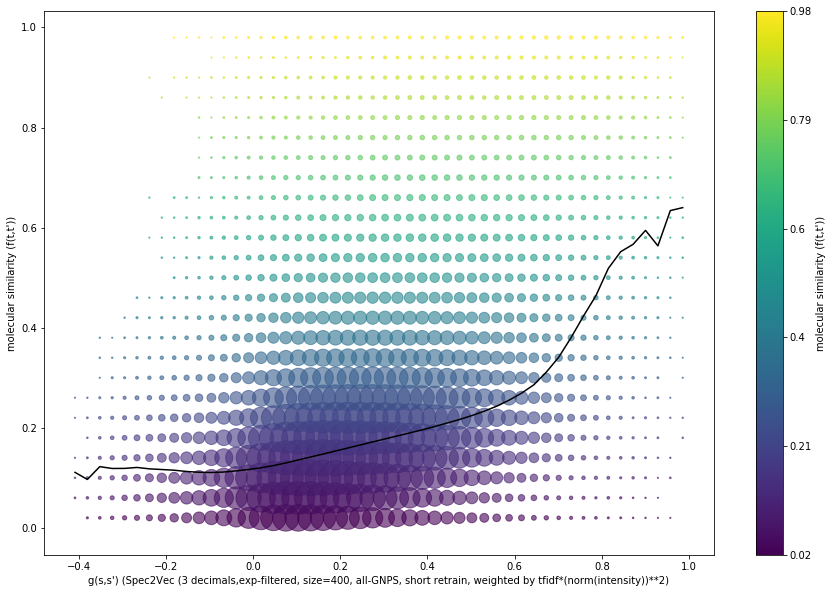

In [25]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (3 decimals,exp-filtered, size=400, all-GNPS, short retrain, weighted by tfidf*(norm(intensity))**2")

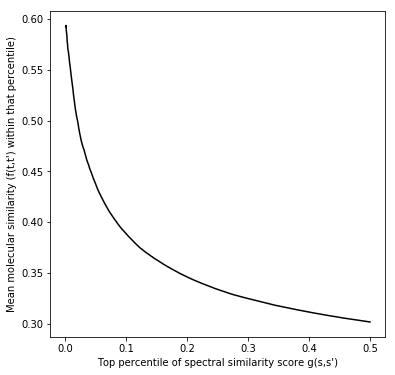

In [26]:
ref_score_w2v_cum_8 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

# 7. Compare to Word2Vec model trained on all-GNPS with 1 decimal resolution

In [49]:
# Import / Load data from gnps/unique smiles dataset
results_file = "filtered_data_uniquesmiles_minpeak10_loss500_1dec_exp001.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 1,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\data\ filtered_data_uniquesmiles_minpeak10_loss500_1dec_exp001.json
Data will be imported from  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\labeled_MS_data\GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf
Loaded 11134 molecules
RuntimeError for  77  peaks. Use mean intensity as threshold.
RuntimeError for  54  peaks. Use mean intensity as threshold.
Unclear TypeError for  100  peaks. Use mean intensity as threshold.
[] and y:  []
RuntimeError for  123  peaks. Use mean intensity as threshold.
RuntimeError for  92  peaks. Use mean intensity as threshold.


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\MS_functions.py:283: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\scipy\optimize\minpack.py:780: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq


Take  9550 spectra out of  11134 .
  Created documents for  1000  of  9550  spectra.No losses detected for:  1035 2836
No losses detected for:  1047 2857
No losses detected for:  1074 2916
  Created documents for  1200  of  9550  spectra.No losses detected for:  1237 3341
No losses detected for:  1277 3451
  Created documents for  1300  of  9550  spectra.No losses detected for:  1339 3601
No losses detected for:  1395 3717
  Created documents for  1500  of  9550  spectra.No losses detected for:  1570 4131
  Created documents for  1800  of  9550  spectra.No losses detected for:  1849 4649
  Created documents for  1900  of  9550  spectra.No losses detected for:  1936 4806
  Created documents for  2100  of  9550  spectra.No losses detected for:  2107 5113
No losses detected for:  2115 5130
No losses detected for:  2127 5151
No losses detected for:  2190 5270
  Created documents for  2200  of  9550  spectra.No losses detected for:  2218 5314
No losses detected for:  2219 5315
  Created doc

In [50]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

In [51]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  14023


***
## 7.1. Pre-trained Word2Vec model (1 decimals) + words vectors weighted by tfidf * sqrt(norm(intensity))

In [52]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec1_exp001.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [53]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
101  out of  14023  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.Calculated centroid vectors for  410  of  9550  documents.  of  9550  documents. 2660  of  9550  documents. Calculated centroid vectors for  7890  of  9550  documents. Calculated centroid vectors for  9130  of  9550  documents.

In [54]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_1_1 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [55]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_1_1.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

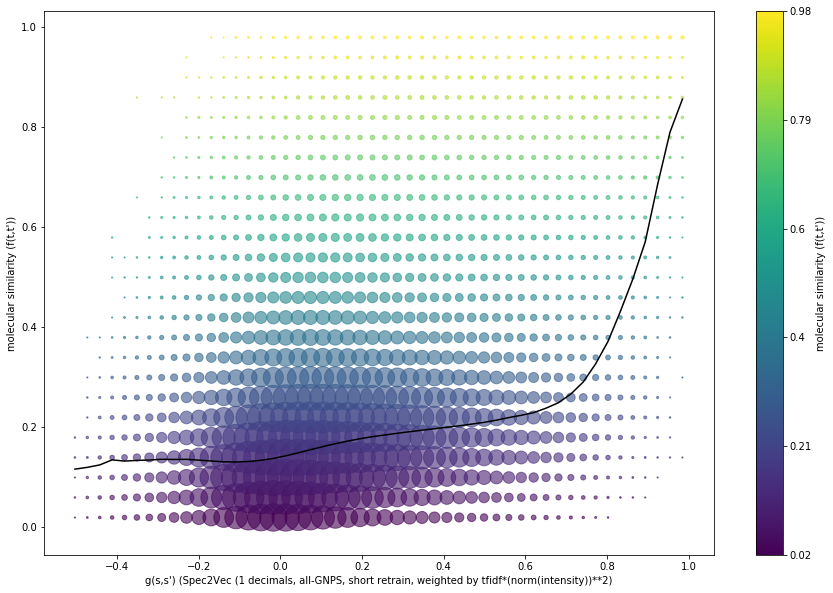

In [56]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (1 decimals, all-GNPS, short retrain, weighted by tfidf*(norm(intensity))**2")

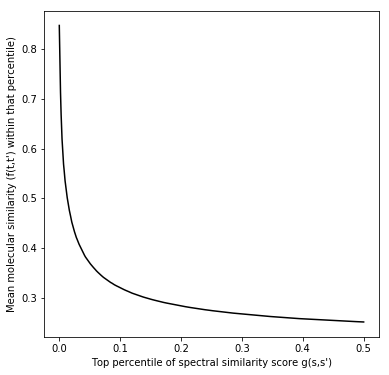

In [57]:
ref_score_w2v_cum_1_1 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

# 8. Model trained on all-merged (> 430,000 spectra)

+ Model was trained on **all-merged dataset** (about 500,000 + 11,000 spectra, 436760 of which were kept and used for training)

### Combine "documents" from the all-GNPS and unique-smiles dataset:

### Filtering: both all-gnps and unique-smiles filtered using exponential filter (0.01). 

In [ ]:
spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], 
                 sub_spectra = False)


PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"
results_file = "filtered_data_uniquesmiles_minpeak10_loss500_2dec_exp001.json"

spectra2, spectra_dict2, MS_documents2, MS_documents_intensity2, sub_spectra_metadata2 = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

In [ ]:
# Combine both corpuses
MS_documents_combined = MS_documents + MS_documents2
MS_documents_intensity_combined = MS_documents_intensity + MS_documents_intensity2

In [ ]:
from Similarities import SimilarityMeasures
MS_measure = SimilarityMeasures(MS_documents_combined)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

In [23]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allmerged_d400_w500_iter100_loss500_minpeak10_dec2_exp001.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=400, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [24]:
len(MS_measure.model_word2vec.wv.vocab)

144868

## Notes:
+ With 100 iteration, the training takes about 2-3 hours on my laptop, so still quite OK.
+ The model has 144868 unique words. This is **very close to the possible maximum number of words** for the parameters chosen here. With peaks between 0 and 1000 Da and losses between 5 and 500 Da with a resolution of 2 decimals. That would be 100,000 + 49,500 = 149500 possible words.

***
## 8.1. 2 decimal model, weighted by tfidf * sqrt(norm(intensity))

In [25]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents.9550  documents.

In [26]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [27]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

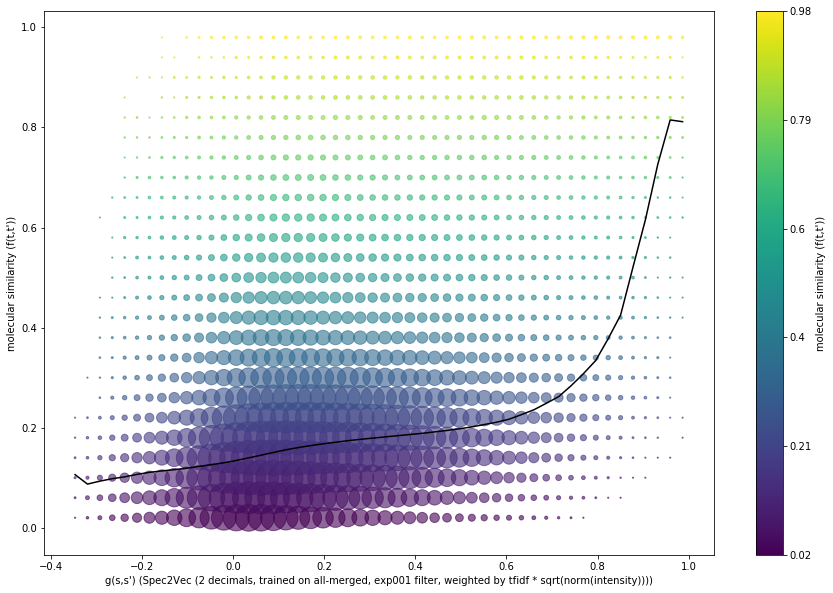

In [28]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (2 decimals, trained on all-merged, exp001 filter, weighted by tfidf * sqrt(norm(intensity)))")

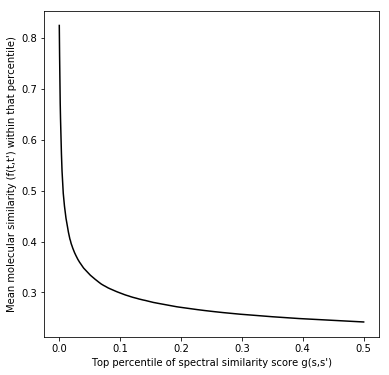

In [29]:
ref_score_w2v_merged_dec2_exp001_iter100_d400 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_merged_dec2_exp001_iter100_d400.npy', ref_score_w2v_merged_dec2_exp001_iter100_d400)

### Combine "documents" from the all-GNPS and unique-smiles dataset:

#### Careful: here combined with **TWO DIFFERENT FILTERING TECHNIQUES**!

In [ ]:
results_file = "filtered_data_allgnps_minpeak10_loss500_2dec_no-exp.json"
spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = None, #0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

results_file = "filtered_data_uniquesmiles_minpeak10_loss500_2dec_exp001.json"
spectra2, spectra_dict2, MS_documents2, MS_documents_intensity2, sub_spectra_metadata2 = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

In [ ]:
# Combine both corpuses
MS_documents_combined = MS_documents + MS_documents2
MS_documents_intensity_combined = MS_documents_intensity + MS_documents_intensity2

In [ ]:
from Similarities import SimilarityMeasures
MS_measure = SimilarityMeasures(MS_documents_combined)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

In [51]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allmerged_d300_w500_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [47]:
len(MS_measure.model_word2vec.wv.vocab)

144868

## Notes:
+ With 100 iteration, the training takes about 2-3 hours on my laptop, so still quite OK.
+ The model has 144868 unique words. This is **very close to the possible maximum number of words** for the parameters chosen here. With peaks between 0 and 1000 Da and losses between 5 and 500 Da with a resolution of 2 decimals. That would be 100,000 + 49,500 = 149500 possible words.

***
## 8.1. 2 decimal model, weighted by tfidf * sqrt(norm(intensity))

In [52]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.2540  of  9550  documents. 9550  documents.

In [53]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_merged_2_0 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [54]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_merged_2_0.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

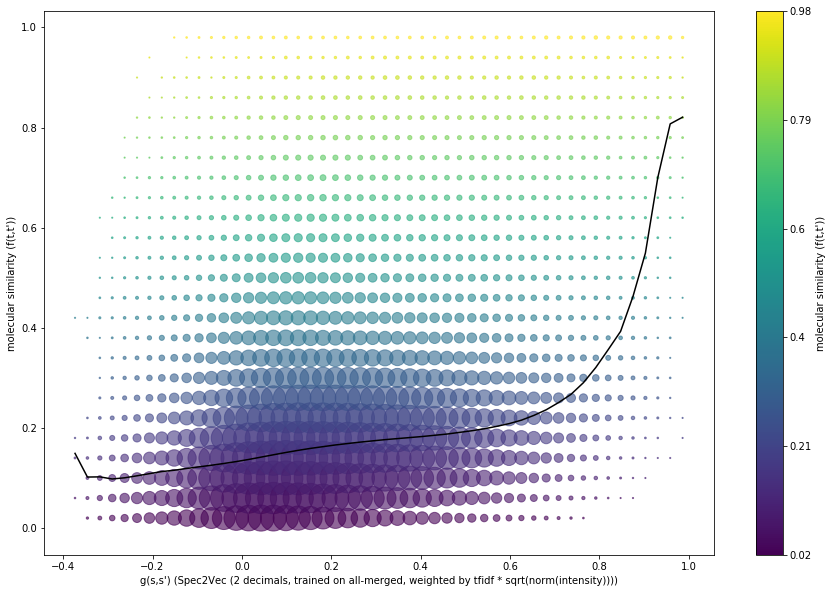

In [55]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (2 decimals, trained on all-merged, weighted by tfidf * sqrt(norm(intensity)))")

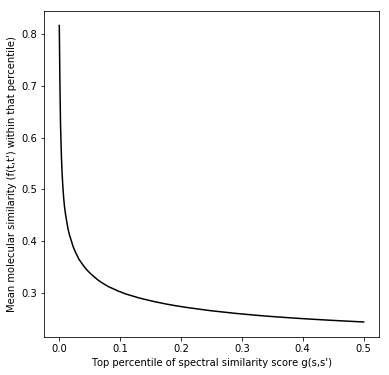

In [56]:
ref_score_w2v_cum_merged_2_0 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_allmerged_2_0.npy', ref_score_w2v_cum_merged_2_0)

In [57]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allmerged_d400_w500_iter10_loss500_minpeak10_dec2_no-filter.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=400, window=500, 
                             min_count=1, workers=4, iter=10, 
                             use_stored_model=True)

Load stored word2vec model ...


***
## 8.1. 2 decimal model, weighted by tfidf * sqrt(norm(intensity))

In [58]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. Calculated centroid vectors for  2460  of  9550  documents. 5120  of  9550  documents. Calculated centroid vectors for  5600  of  9550  documents.  documents. documents. Calculated centroid vectors for  6360  of  9550  documents.

In [59]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_merged_2_0 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [60]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_merged_2_0.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

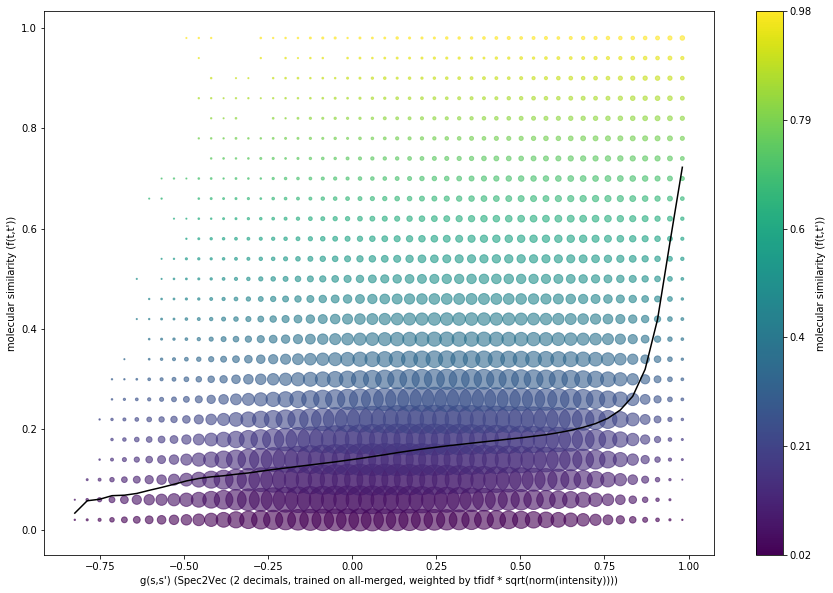

In [61]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (2 decimals, trained on all-merged, weighted by tfidf * sqrt(norm(intensity)))")

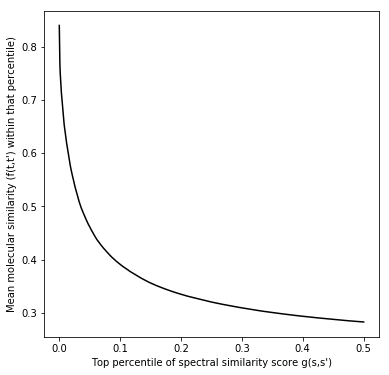

In [62]:
ref_score_w2v_cum_merged_2_0 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_allmerged_2_0.npy', ref_score_w2v_cum_merged_2_0)

## Comparison plots

In [45]:
ref_score_cosine_cum002 = np.load('cosine_percentile_tol002_minmatch6.npy')
ref_score_cosine_cum0005 = np.load('cosine_percentile_tol0005_minmatch6.npy')

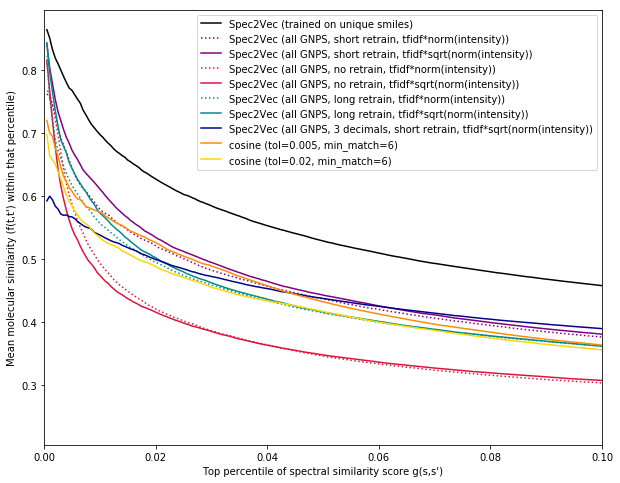

In [116]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

cmap1 = matplotlib.cm.get_cmap("gnuplot") #('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(10,8))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_0, color='black',
         label='Spec2Vec (trained on unique smiles)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_1, ':', 
         color='purple', #cmap1(0.0), 
         label='Spec2Vec (all GNPS, short retrain, tfidf*norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2, 
         color='purple', #(0.2), 
         label='Spec2Vec (all GNPS, short retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_3, ':', 
         color='crimson', #cmap1(0.4), #'pink',
         label='Spec2Vec (all GNPS, no retrain, tfidf*norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_4, 
         color='crimson', #cmap1(0.5), #'pink',
         label='Spec2Vec (all GNPS, no retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_6, ':', 
         color='darkcyan', #cmap1(0.7), #'pink',
         label='Spec2Vec (all GNPS, long retrain, tfidf*norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_5, 
         color='darkcyan', #cmap1(0.8), #'pink',
         label='Spec2Vec (all GNPS, long retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_7, 
         color='darkblue', #cmap1(1.0), #'pink',
         label='Spec2Vec (all GNPS, 3 decimals, short retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum0005, 
         color='darkorange', #cmap1(1.0), #'pink',
         label='cosine (tol=0.005, min_match=6)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum002, 
         color='gold', #cmap1(1.0), #'pink',
         label='cosine (tol=0.02, min_match=6)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.savefig('Top_percentile_comparison_allGNPS_02.pdf')

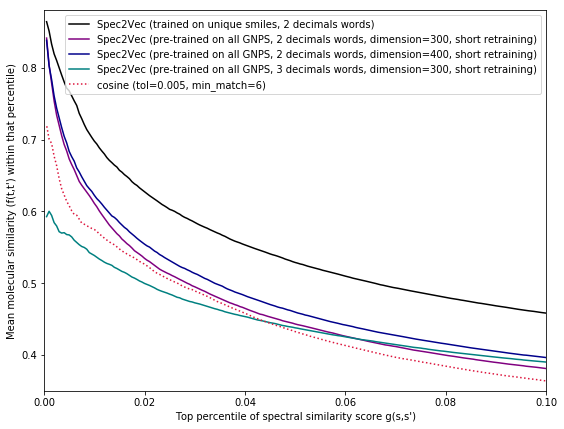

In [49]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

cmap1 = matplotlib.cm.get_cmap("gnuplot") #('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(9,7))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_0, color='black',
         label='Spec2Vec (trained on unique smiles, 2 decimals words)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2, 
         color='purple', #(0.2), 
         label='Spec2Vec (pre-trained on all GNPS, 2 decimals words, dimension=300, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2b, 
         color='darkblue', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, 2 decimals words, dimension=400, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_7, 
         color='teal', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, 3 decimals words, dimension=300, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum0005,':', 
         color='crimson', #cmap1(1.0), #'pink',
         label='cosine (tol=0.005, min_match=6)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.35, 0.88)
plt.savefig('Top_percentile_comparison_allGNPS_03.pdf')

In [114]:
np.save('spec2vec_allGNPS_0.npy', ref_score_w2v_cum_0)
np.save('spec2vec_allGNPS_1.npy', ref_score_w2v_cum_1)
np.save('spec2vec_allGNPS_2.npy', ref_score_w2v_cum_2)
np.save('spec2vec_allGNPS_2b.npy', ref_score_w2v_cum_2b)
np.save('spec2vec_allGNPS_3.npy', ref_score_w2v_cum_3)
np.save('spec2vec_allGNPS_4.npy', ref_score_w2v_cum_4)
np.save('spec2vec_allGNPS_5.npy', ref_score_w2v_cum_5)
np.save('spec2vec_allGNPS_6.npy', ref_score_w2v_cum_6)
np.save('spec2vec_allGNPS_7.npy', ref_score_w2v_cum_7)
np.save('spec2vec_allGNPS_8.npy', ref_score_w2v_cum_8)

In [19]:
# load previously calculated curves
ref_score_w2v_cum_0 = np.load('spec2vec_allGNPS_0.npy')
ref_score_w2v_cum_1 = np.load('spec2vec_allGNPS_1.npy')
ref_score_w2v_cum_2 = np.load('spec2vec_allGNPS_2.npy')
ref_score_w2v_cum_2b = np.load('spec2vec_allGNPS_2b.npy')
ref_score_w2v_cum_3 = np.load('spec2vec_allGNPS_3.npy')
ref_score_w2v_cum_4 = np.load('spec2vec_allGNPS_4.npy')
ref_score_w2v_cum_5 = np.load('spec2vec_allGNPS_5.npy')
ref_score_w2v_cum_6 = np.load('spec2vec_allGNPS_6.npy')
ref_score_w2v_cum_7 = np.load('spec2vec_allGNPS_7.npy')
ref_score_w2v_cum_8 = np.load('spec2vec_allGNPS_8.npy')
#ref_score_w2v_cum_2_7 = np.load('spec2vec_allGNPS_2_7.npy')
ref_score_w2v_cum_2_8 = np.load('spec2vec_allGNPS_2_8.npy')

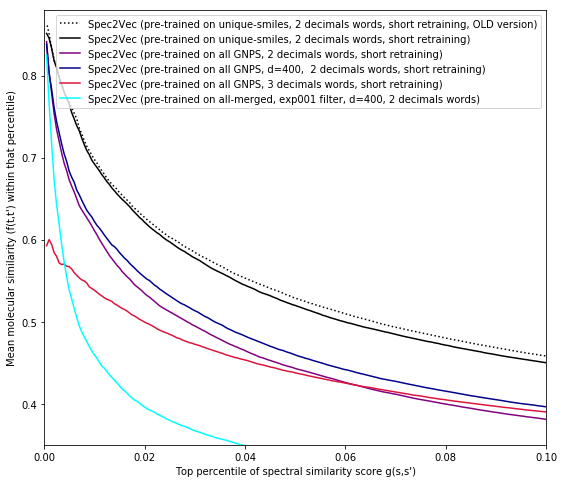

In [32]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

cmap1 = matplotlib.cm.get_cmap("gnuplot") #('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(9,8))

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_0, ':',
         color='black', #(0.2), 
         label='Spec2Vec (pre-trained on unique-smiles, 2 decimals words, short retraining, OLD version)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300, 
         color='black', #(0.2), 
         label='Spec2Vec (pre-trained on unique-smiles, 2 decimals words, short retraining)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_1_1, 
#         color='olive', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, 1 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2, 
         color='purple', #(0.2), 
         label='Spec2Vec (pre-trained on all GNPS, 2 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2b, 
         color='darkblue', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, d=400,  2 decimals words, short retraining)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2_8, 
#         color='blue', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, loss=peak, w=500, iter=100,  2 decimals words, short retraining)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2_9, 
#         color='cyan', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, no losses, w=500, iter=100,  2 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_7, 
         color='crimson', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, 3 decimals words, short retraining)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_8,':', 
#         color='red', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, d = 400, 3 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_merged_dec2_exp001_iter100_d400, 
         color='cyan', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all-merged, exp001 filter, d=400, 2 decimals words)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.35, 0.88)
plt.savefig('Top_percentile_comparison_allGNPS_04.pdf')